Задача:

Реализовать импульсный шум и шум типа соль-перец.

Реализовать 3 типа фильтров изображения:
1. Фильтр размытия
2. Фильтр повышения резкости
3. Медианный фильтр

Реализовать возможность установки ширины окна фильтрации с тем условием, что размер окна должен быть нечетным и больше либо равен 3.

Группа: КВБО-07-21

Выполнили: Бедняков И.В., Брацук А.С., Канаева П.К.

### Импорт библиотек

In [1]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
import random

### Загрузка изображения

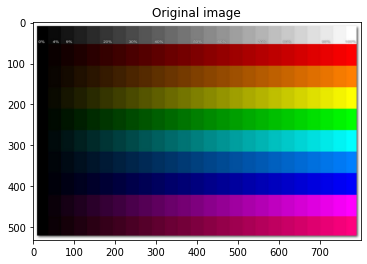

In [2]:
image = cv2.imread("index.png")
b,g,r = cv2.split(image)       
rgb_image = cv2.merge([r,g,b])     
plt.imshow(rgb_image)
plt.title("Original image")
plt.show()

### Создание импульсного шума

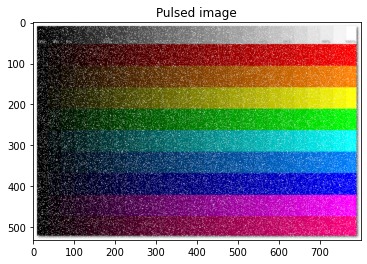

In [3]:
def add_pulse_RGB(img, percent):
    """
    На изображение накладывается импульсный шум.
    
    :param img: матрица исходного изображения
    :param percent: примерное количество пикселей, заполненных белым, в процентах
    
    :return merged_bgr: матрица зашумленного изображения
    
    """
    (b, g, r) = cv2.split(image)
    for x in range(b.shape[0]):
        for y in range(b.shape[1]):
            if random.randint(1,100)<percent:
                b[x, y] = 255
                g[x, y] = 255
                r[x, y] = 255
    merged_rgb = cv2.merge([r,g,b])
    merged_bgr = cv2.merge([b,g,r]) 
    plt.imshow(merged_rgb)
    plt.title("Pulsed image")
    plt.show()
    return merged_bgr

peaksImage = add_pulse_RGB(image, 10) #Здесь можно задать проценты

### Создание шума соль-перец

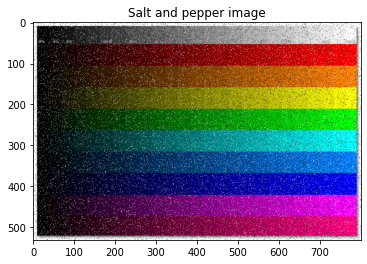

In [4]:
def add_spiceRGB(img, percent):
    """
    На изображение накладывается шум вида соль-перец.
    
    :param img: матрица исходного изображения
    :param percent: примерное количество пикселей, заполненных белым или черным, в процентах
    
    :return merged_bgr: матрица зашумленного изображения
    
    """
    (b, g, r) = cv2.split(image)
    for x in range(b.shape[0]):
        for y in range(b.shape[1]):
            if random.randint(1,100)<percent:
                spice = random.randint(0,1)*255
                b[x, y] = spice
                g[x, y] = spice
                r[x, y] = spice
    merged_rgb = cv2.merge([r,g,b])
    merged_bgr = cv2.merge([b,g,r]) 
    plt.imshow(merged_rgb)
    plt.title("Salt and pepper image")
    plt.show()
    return merged_bgr

seasonedImage = add_spiceRGB(image, 10) #Здесь можно задать проценты

### Создание общих функций

In [5]:
def convolve(sub, kern):
    """
    Выполнение операции свертки.
    
    :param sub: подматрица исходного изображения, соответствующая размеру ядра
    :param kern: ядро фильтра
    
    :return res: результат операции свертки
    
    """
    res = np.sum(np.multiply(sub, kern))
    if res > 255:
        res = 255
    elif res < 0:
        res = 0
    return int(res)

def extendColor(arr, side):
    """
    Расширение изображения с использованием цветов крайних пикселей изображения.
    
    :param arr: матрица исходного изображения
    :param side: длина стороны ядра в пикселях
    
    :return arr: расширенное изображение
    
    """
    #Приклеивание последней полоски пикселей с каждого края изображения
    arr = np.vstack([np.array([arr.T[0]]*(side//2)), arr.T, np.array([arr.T[arr.T.shape[0]-1]]*(side//2))], dtype='uint8') 
    arr = np.vstack([np.array([arr.T[0]]*(side//2)), arr.T, np.array([arr.T[arr.T.shape[0]-1]]*(side//2))], dtype='uint8')
    return arr

### Размытие по Гауссу
Это может быть немного долго

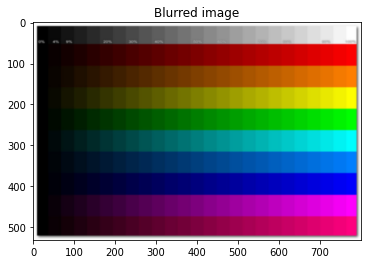

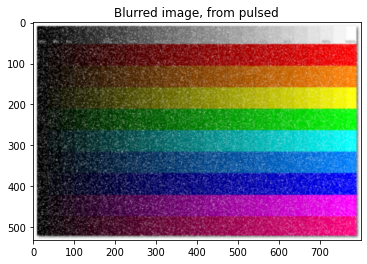

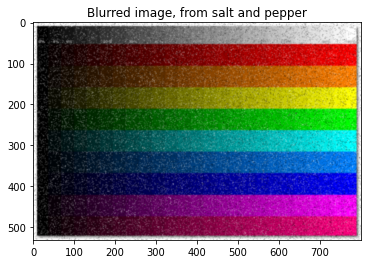

In [6]:
def gauss(x, sigma):
    """
    Реализация функции Гаусса.
    
    :param x: координата точки для функции Гаусса
    :param sigma: среднеквадратичное отклонение нормального распределения
    
    :return res: результат функции Гаусса
    
    """
    res = 1/np.sqrt(2*3.1416*sigma**2)*np.exp(-(x**2)/(2*sigma**2))
    return res

def blur(side, arr):
    """
    Реализация фильтра размытия для монохромного изображения.
    
    :param side: длина стороны фильтра
    :param arr: матрица монохромного изображения
    
    :return newarr: получаемое изображение в результате фильтрации
    
    """
    sigma = (side-1)/6 if side > 3 else 0.6
    diap = np.linspace(-(side - 1) / 2, (side - 1) / 2, side) #Задаем по стороне фильтра диапазон для генерации ядра типа [-2,-1,0,1,2]
    d1kern = np.array(list(map(gauss, diap, [sigma]*side))) #Считаем  1-мерное ядро 
    kern = np.outer(d1kern, d1kern) #Перемножением 1-мерных ядер делаем 2-мерное ядро
    newarr = np.zeros(arr.shape, dtype = "uint8") #Делаем пустой массив размером с нашу картинку
    arr = extendColor(arr, side)
   #Производим свертку, проходясь по каждому пикселю исходного изображения
    for y in range(side//2, arr.shape[1]-side//2):
        for x in range(side//2, arr.shape[0]-side//2):
            sub = arr[x-side//2:(x+side//2+1), y-side//2:(y+side//2+1)]
            newarr[x-side//2,y-side//2] = convolve(sub, kern)
    return newarr

def blurRGB(image, side):
    """
    Реализация фильтра размытия для цветного rgb изображения с выводом полученного изображения.
    
    :param image: матрица исходного изображения
    :param side: длина стороны ядра в пикселях
    
    :return merged_bgr: получаемое изображение в результате фильтрации
    
    """
    (b, g, r) = cv2.split(image)
    b = blur(side, b)
    g = blur(side, g)
    r = blur(side, r)
    merged_rgb = cv2.merge([r,g,b])
    merged_bgr = cv2.merge([b,g,r]) 
    plt.imshow(merged_rgb)
    plt.show()
    return merged_bgr

plt.title("Blurred image")
blurred = blurRGB(image, 7)
plt.title("Blurred image, from pulsed")
_ = blurRGB(peaksImage,7)
plt.title("Blurred image, from salt and pepper")
_ = blurRGB(seasonedImage,7)

### Фильтр повышения резкости

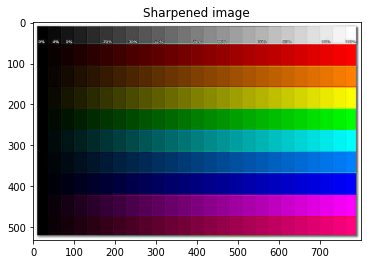

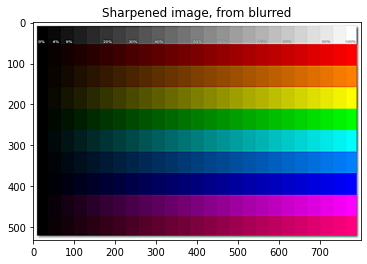

In [7]:
def sharp(arr, side=3):
    """
    Реализация фильтра повышения резкости для монохромного изображения.
    
    :param arr: матрица исходного изображения
    :param side: длина стороны ядра в пикселях
    
    :return newarr: получаемое изображение в результате фильтрации
    
    """
    kern = -np.ones((side,side))
    kern[side//2,side//2]=side**2
    newarr = np.zeros(arr.shape, dtype = "uint8") #Делаем пустой массив размером с нашу картинку
    arr = extendColor(arr, side)
    for y in range(side//2, arr.shape[1]-side//2):
        for x in range(side//2, arr.shape[0]-side//2):
            sub = arr[x-side//2:(x+side//2+1), y-side//2:(y+side//2+1)]
            newarr[x-side//2,y-side//2] = convolve(sub, kern)
    return newarr

def sharpRGB(image, side):
    """
    Реализация фильтра повышения резкости для цветного rgb изображения с выводом полученного изображения.
    
    :param image: матрица исходного изображения
    :param side: длина стороны ядра в пикселях
    
    """
    (b, g, r) = cv2.split(image)
    b = sharp(b, side)
    g = sharp(g, side)
    r = sharp(r, side)
    merged_rgb = cv2.merge([r,g,b])
    plt.imshow(merged_rgb)
    plt.show()

plt.title("Sharpened image")
sharpRGB(image, 3)
plt.title("Sharpened image, from blurred")
sharpRGB(blurred, 3)

### Медианный фильтр

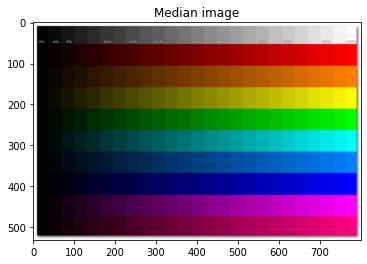

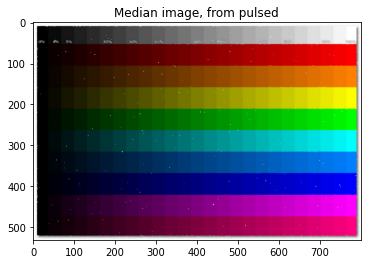

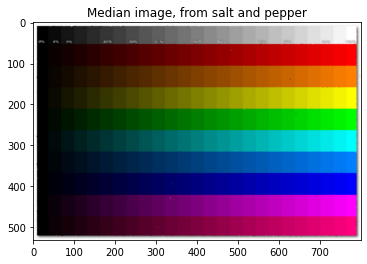

In [9]:
def median(arr, side=3):
    """
    Реализация медианного фильтра для монохромного изображения.
    
    :param arr: матрица исходного изображения
    :param side: длина стороны ядра в пикселях
    
    :return newarr: получаемое изображение в результате фильтрации
    
    """
    newarr = np.zeros(arr.shape, dtype = "uint8") #Делаем пустой массив размером с нашу картинку
    arr = extendColor(arr, side)
    for y in range(side//2, arr.shape[1]-side//2):
        for x in range(side//2, arr.shape[0]-side//2):
            sub = arr[x-side//2:(x+side//2+1), y-side//2:(y+side//2+1)]
            newarr[x-side//2,y-side//2] = np.sort(sub.flatten())[side**2//2]
    return newarr

def medianRGB(image, side):
    """
    Реализация медианного фильтра для цветного rgb изображения с выводом полученного изображения.
    
    :param image: матрица исходного изображения
    :param side: длина стороны окна фильтрации
    
    """
    (b, g, r) = cv2.split(image)
    b = median(b, side)
    g = median(g, side)
    r = median(r, side)
    merged_rgb = cv2.merge([r,g,b])
    plt.imshow(merged_rgb)
    plt.show()
    
plt.title("Median image")
medianRGB(image, 3)
plt.title("Median image, from pulsed")
medianRGB(peaksImage, 3)
plt.title("Median image, from salt and pepper")
medianRGB(seasonedImage, 3)